<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_MONTH       28820 non-null  int64  
 2   DAY_OF_WEEK        28820 non-null  int64  
 3   OP_UNIQUE_CARRIER  28820 non-null  object 
 4   TAIL_NUM           28820 non-null  object 
 5   DEST               28820 non-null  object 
 6   DEP_DELAY          28820 non-null  int64  
 7   CRS_ELAPSED_TIME   28820 non-null  int64  
 8   DISTANCE           28820 non-null  int64  
 9   CRS_DEP_M          28820 non-null  int64  
 10  DEP_TIME_M         28820 non-null  int64  
 11  CRS_ARR_M          28820 non-null  int64  
 12  Temperature        28820 non-null  int64  
 13  Dew Point          28820 non-null  object 
 14  Humidity           28820 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         288

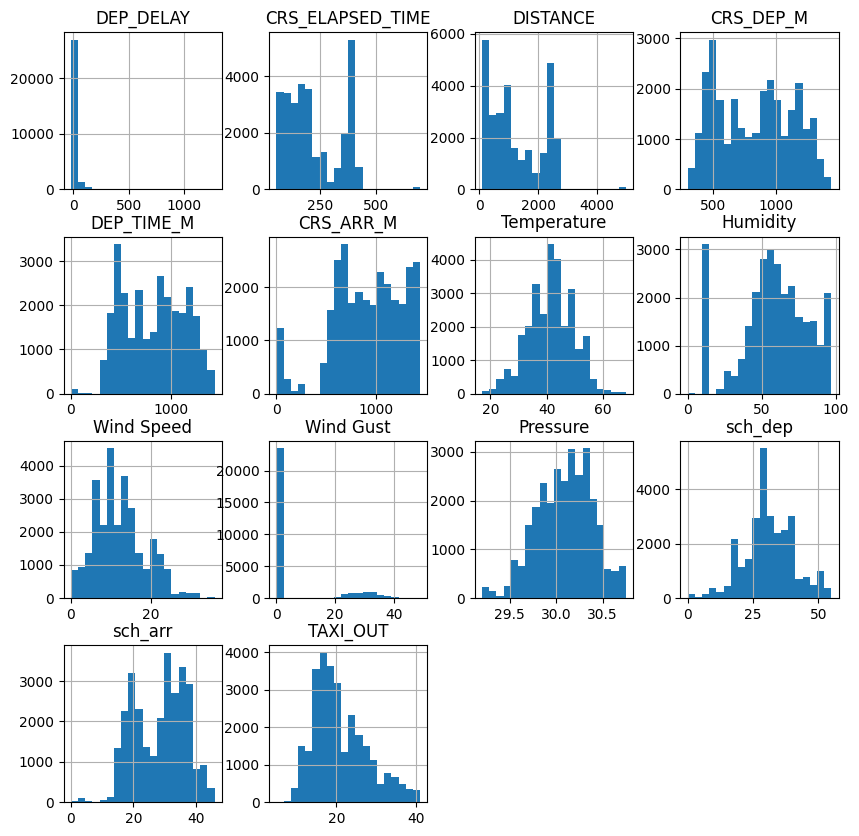

In [163]:
# import packages and functions for data analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import time

# load data set
air_data = pd.read_csv('M1_final.csv')

# show what a typical set of data looks like
air_data.head()

# see the data types and if there is any null data in the dataset
air_data.info()
air_data.isnull().sum()

# select only the numeric columns for analysis
ad = air_data.select_dtypes(include='number')

# data histograms to see shape of data and any outliers - excluding month, day of the week and day of the month
ad.iloc[:,3:].hist(bins=20, figsize=(10,10))
plt.savefig('airport_plots/overall_hist.png')

#ad.head()

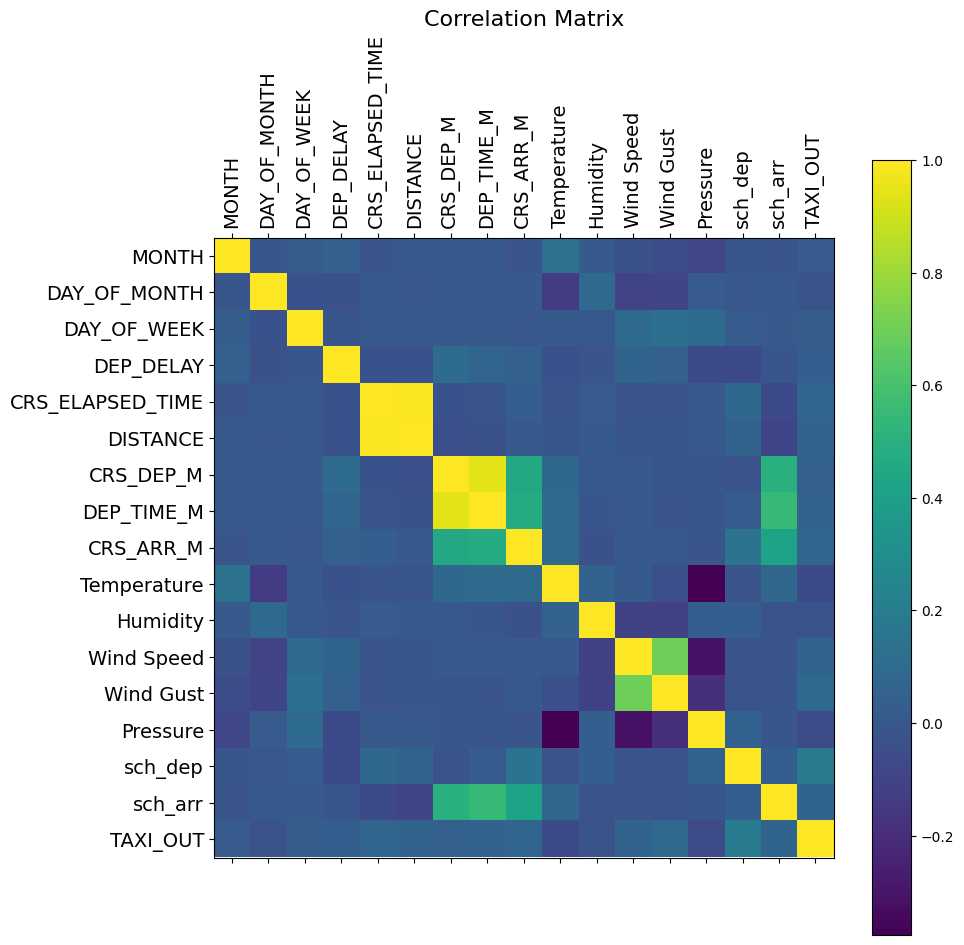

In [117]:
# correlation matrix

fig = plt.figure(figsize=(10,10))
plt.matshow(ad.corr(), fignum=fig.number)
plt.xticks(range(ad.shape[1]), ad.columns, fontsize=14, rotation=90)
plt.yticks(range(ad.shape[1]), ad.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=16);
plt.savefig('airport_plots/corr_matrix.png')

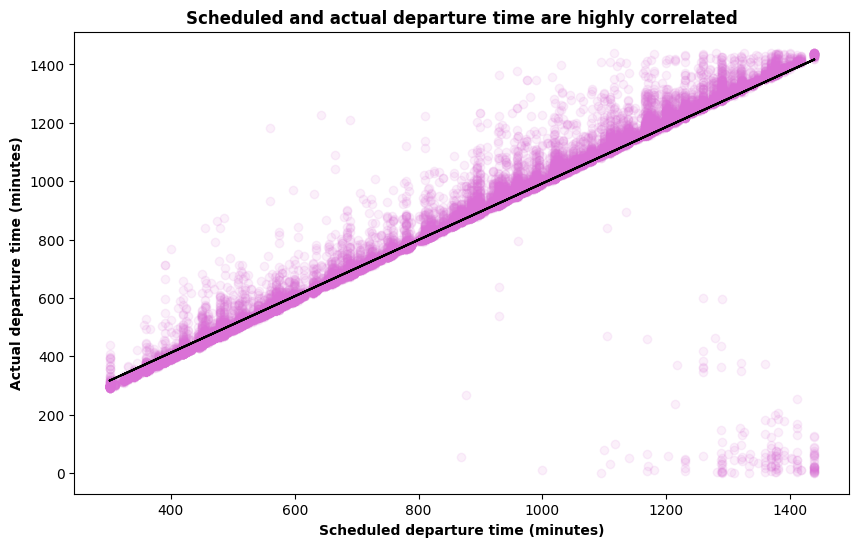

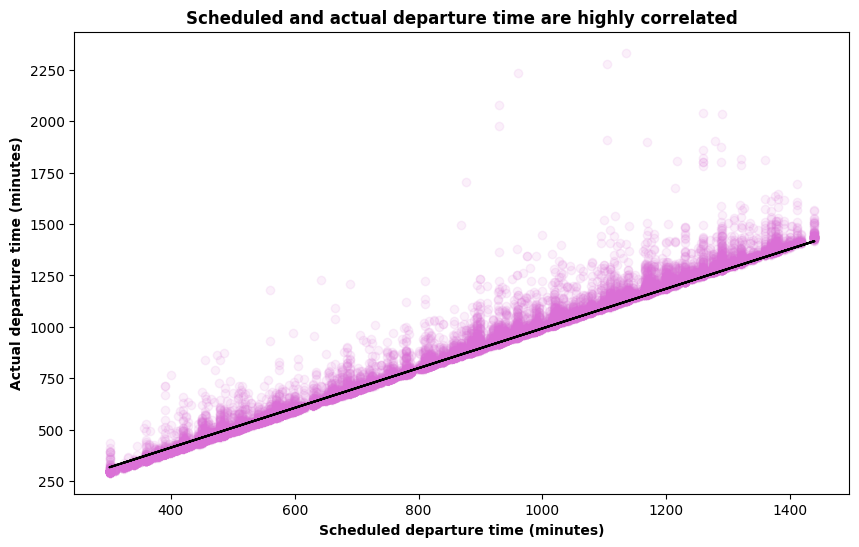

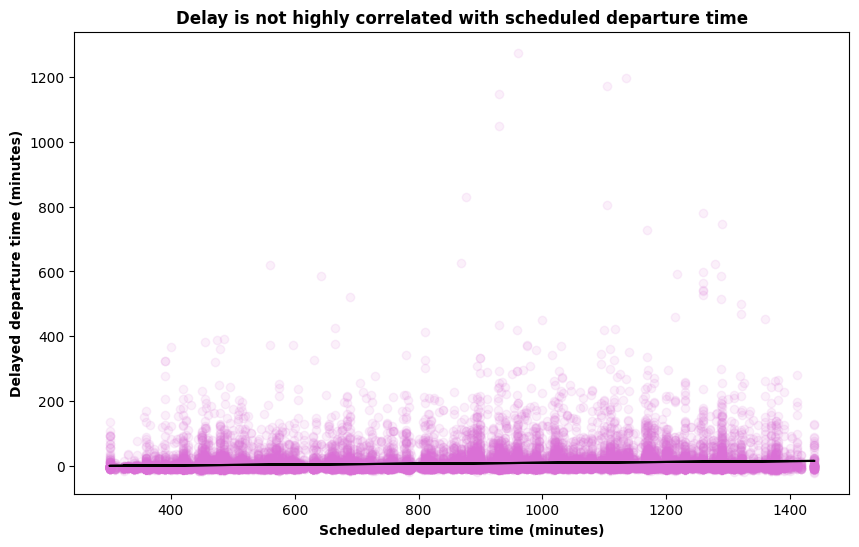

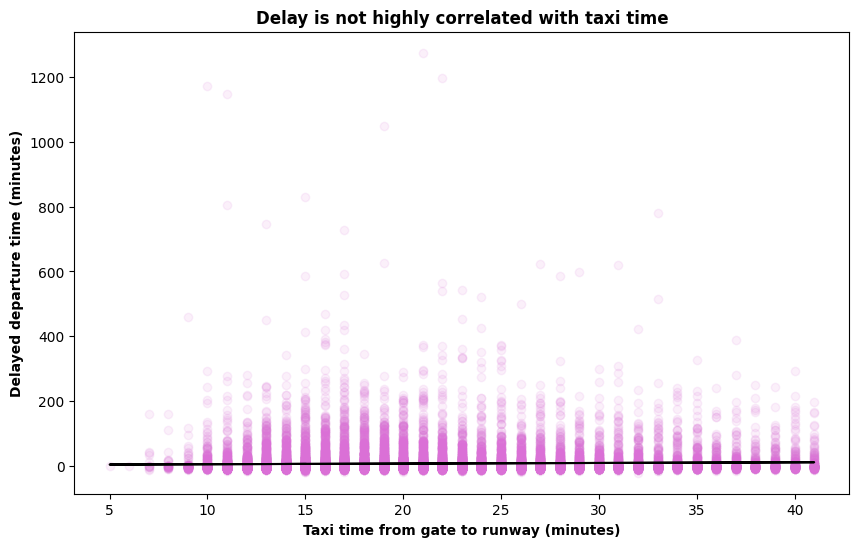

In [115]:
# scatter plot with line of best fit for correlated data: scheduled departule time and actual departure time
air_data = pd.read_csv('M1_final.csv')
# select only the numeric columns for analysis
ad = air_data.select_dtypes(include='number')

fig, ax = plt.subplots(figsize= (10,6))
ax.scatter(ad['CRS_DEP_M'], ad['DEP_TIME_M'], alpha=0.1, color = 'orchid')

# aesthetics
ax.set_ylabel("Actual departure time (minutes)", fontweight='bold')
ax.set_xlabel("Scheduled departure time (minutes)", fontweight='bold')
ax.set_title("Scheduled and actual departure time are highly correlated", fontweight='bold')

# line of best fit using linear regression

x1 = ad.loc[:,'CRS_DEP_M'].values.reshape(-1,1)
y1 = ad.loc[:,'DEP_TIME_M'].values.reshape(-1,1)
LR1 = LinearRegression()
LR1.fit(x1,y1)
y_pred1 = LR1.predict(x1)
plt.plot(x1, y_pred1, color='black')
plt.savefig('airport_plots/actual_dep_vs_sch_dep.png')

# make it so time doesn't overlap and reset back to 0 at the start of a new day
ad_time_fixed = ad

for i in range(ad.shape[0]):
    if ad_time_fixed.loc[i, 'CRS_DEP_M'] - 50 > ad_time_fixed.loc[i, 'DEP_TIME_M']:
        ad_time_fixed.loc[i, 'DEP_TIME_M'] = ad_time_fixed.loc[i, 'DEP_TIME_M'] + 1440

fig2, ax2 = plt.subplots(figsize= (10,6))
ax2.scatter(ad_time_fixed['CRS_DEP_M'], ad_time_fixed['DEP_TIME_M'], alpha=0.1, color = 'orchid')

# aesthetics
ax2.set_ylabel("Actual departure time (minutes)", fontweight='bold')
ax2.set_xlabel("Scheduled departure time (minutes)", fontweight='bold')
ax2.set_title("Scheduled and actual departure time are highly correlated", fontweight='bold')

# line of best fit using linear regression

x2 = ad_time_fixed.loc[:,'CRS_DEP_M'].values.reshape(-1,1)
y2 = ad_time_fixed.loc[:,'DEP_TIME_M'].values.reshape(-1,1)
LR2 = LinearRegression()
LR2.fit(x2,y2)
y_pred2 = LR1.predict(x2)
plt.plot(x2, y_pred2, color='black')
plt.savefig('airport_plots/actual_dep_vs_sch_dep_fixed_time.png')


# plot delay against scheduled departure time
# find the delay
delay = y2 - x2

# find line of best fit for delay and scheduled departure time
LR3 = LinearRegression()
LR3.fit(x2,delay)
y_pred3 = LR3.predict(x2)

# plot delay vs scheduled departure time and line of best fit
fig3, ax3 = plt.subplots(figsize= (10,6))
ax3.scatter(x2, delay, alpha=0.1, color = 'orchid')
plt.plot(x2, y_pred3, color='black')

# aesthetics
ax3.set_ylabel("Delayed departure time (minutes)", fontweight='bold')
ax3.set_xlabel("Scheduled departure time (minutes)", fontweight='bold')
ax3.set_title("Delay is not highly correlated with scheduled departure time", fontweight='bold')
plt.savefig('airport_plots/delay_dep_vs_sch_dep.png')

# plot delay vs taxi out with line of best fit
fig4, ax4 = plt.subplots(figsize= (10,6))
ax4.scatter(ad['TAXI_OUT'], delay, alpha=0.1, color = 'orchid')
LR4 = LinearRegression()
LR4.fit(ad.loc[:,'TAXI_OUT'].values.reshape(-1,1), delay)
y_pred4 = LR4.predict(ad.loc[:,'TAXI_OUT'].values.reshape(-1,1))

plt.plot(ad.loc[:,'TAXI_OUT'].values.reshape(-1,1), y_pred4, color='black')

# aesthetics
ax4.set_ylabel("Delayed departure time (minutes)", fontweight='bold')
ax4.set_xlabel("Taxi time from gate to runway (minutes)", fontweight='bold')
ax4.set_title("Delay is not highly correlated with taxi time", fontweight='bold')
plt.savefig('airport_plots/taxi_out_vs_delay_dep.png')


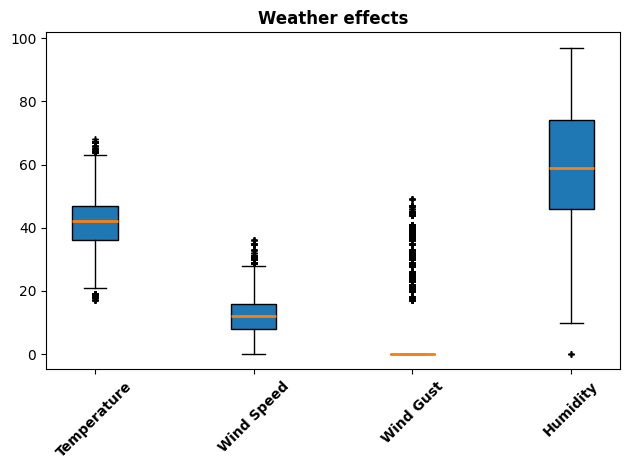

In [121]:
# box plot of weather effects
# list of columns to plot
columns = ['Temperature', 'Wind Speed', 'Wind Gust', 'Humidity']
# set up aethetics for box plots
outliers = dict(marker='+', markersize = 5, markerfacecolor='black')
medians = dict(linewidth=2)
fig, ax = plt.subplots()
x = 0

for column in columns:
    temp = ad[column]
    
    # draw boxplot at appropriate position
    ax.boxplot(temp, positions=[x],
                widths=2,
                patch_artist=True,
                medianprops=medians,
                flierprops=outliers)
    x += 7

# aethetics
ax.set_xticks(np.arange(0,(len(columns)-1)*7+1,7))
ax.set_xticklabels(columns, fontweight='bold', rotation=45)
ax.set_title("Weather effects", fontweight='bold')
fig.tight_layout()
plt.savefig("airport_plots/box_plots.png")

In [185]:
# data splitting, using 20% of data for testing and 80% for training
x = ad.iloc[:,:16]
y = ad.iloc[:,16]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=6)

# feature scaling - using standard scalar to set mean to 0 and variance to 1
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# create dataframe to store accuracy data for each regression model
acc_db = pd.DataFrame(columns=['R-squared', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error', 'Run Time (s)'])

In [186]:
# create multi linear regression using Ordinary Least Squares
start = time.time()
lin_reg = LinearRegression()
# train the model
lin_reg.fit(x_train,y_train)
# test model on test data
y_pred_lin_reg = lin_reg.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_lin_reg = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lin_reg})

# compute accuracy statistics
R2 = metrics.r2_score(y_test, y_pred_lin_reg)
MAE = metrics.mean_absolute_error(y_test, y_pred_lin_reg)
RMSE = metrics.root_mean_squared_error(y_test, y_pred_lin_reg)
MSE = RMSE**2

# add statistics to database
acc_db.loc['Linear Regression'] = [R2, MAE, RMSE, MSE, run_time]

acc_db

,R-squared,Mean Absolute Error,Root Mean Squared Error,Mean Squared Error,Run Time (s)
Linear Regression,0.077485,5.242214,6.589638,43.423329,0.034746


In [188]:
# Lasso model with variable alpha
start = time.time()
alpha = 0.001
model_lasso = Lasso(alpha)
# train the model
model_lasso.fit(x_train,y_train)
# test model on test data
y_pred_lasso = model_lasso.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_lasso = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lasso})

# compute accuracy statistics
R2 = metrics.r2_score(y_test, y_pred_lasso)
MAE = metrics.mean_absolute_error(y_test, y_pred_lasso)
RMSE = metrics.root_mean_squared_error(y_test, y_pred_lasso)
MSE = RMSE**2

# add statistics to database
acc_db.loc['Lasso '+chr(945)+'='+str(alpha)] = [R2, MAE, RMSE, MSE, run_time]

acc_db

,R-squared,Mean Absolute Error,Root Mean Squared Error,Mean Squared Error,Run Time (s)
Linear Regression,0.077485,5.242214,6.589638,43.423329,0.034746
Lasso α=0.1,0.070381,5.274662,6.614962,43.757726,0.744994
Lasso α=0.001,0.077507,5.242474,6.589561,43.422317,2.998324


In [190]:
# Ridge model with variable alpha
start = time.time()
alpha = 0.001
model_ridge = Ridge(alpha)
# train the model
model_ridge.fit(x_train,y_train)
# test model on test data
y_pred_ridge = model_ridge.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_ridge = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_ridge})

# compute accuracy statistics
R2 = metrics.r2_score(y_test, y_pred_ridge)
MAE = metrics.mean_absolute_error(y_test, y_pred_ridge)
RMSE = metrics.root_mean_squared_error(y_test, y_pred_ridge)
MSE = RMSE**2

# add statistics to database
acc_db.loc['Ridge '+chr(945)+'='+str(alpha)] = [R2, MAE, RMSE, MSE, run_time]

acc_db

,R-squared,Mean Absolute Error,Root Mean Squared Error,Mean Squared Error,Run Time (s)
Linear Regression,0.077485,5.242214,6.589638,43.423329,0.034746
Lasso α=0.1,0.070381,5.274662,6.614962,43.757726,0.744994
Lasso α=0.001,0.077507,5.242474,6.589561,43.422317,2.998324
Ridge α=0.1,0.077486,5.242218,6.589636,43.423308,0.014880
Ridge α=0.001,0.077485,5.242214,6.589638,43.423328,0.005951


In [148]:
# Finding suitable alpha by repeated k fold analysis
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
# define model
model = RidgeCV(alphas=np.arange(0.001,10,0.05), cv = cv, scoring = "neg_mean_absolute_error")
# train the model
model.fit(x_train,y_train)

# summarise the chosen configuration
print(model.alpha_)

0.001


In [195]:
# support vector regressor with variable kernel - options: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’}
start = time.time()
kernel = 'sigmoid'
svr = SVR(kernel=kernel)
# train the model
svr.fit(x_train,y_train)
# test model on test data
y_pred_svr = svr.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# compute accuracy statistics
R2 = metrics.r2_score(y_test, y_pred_svr)
MAE = metrics.mean_absolute_error(y_test, y_pred_svr)
RMSE = metrics.root_mean_squared_error(y_test, y_pred_svr)
MSE = RMSE**2

# add statistics to database
acc_db.loc['Support Vector kernel='+kernel] = [R2, MAE, RMSE, MSE, run_time]

acc_db

,R-squared,Mean Absolute Error,Root Mean Squared Error,Mean Squared Error,Run Time (s)
Linear Regression,0.077485,5.242214,6.589638,43.423329,0.034746
Lasso α=0.1,0.070381,5.274662,6.614962,43.757726,0.744994
Lasso α=0.001,0.077507,5.242474,6.589561,43.422317,2.998324
Ridge α=0.1,0.077486,5.242218,6.589636,43.423308,0.014880
Ridge α=0.001,0.077485,5.242214,6.589638,43.423328,0.005951
Support Vector kernel=linear,0.042806,5.172105,6.712355,45.055705,32.912118
Support Vector kernel=poly,0.114094,4.986637,6.457566,41.700154,24.844671
Support Vector kernel=rbf,0.136777,4.916013,6.374357,40.632431,36.615756
Support Vector kernel=sigmoid,-97.317799,41.319986,68.028512,4627.878389,50.547662


In [198]:
# random forest regressor with variable number of estimators
start = time.time()
n = 1000
rf_reg = RandomForestRegressor(n_estimators=n)
# train the model
rf_reg.fit(x_train,y_train)
# test model on test data
y_pred_rf_reg = rf_reg.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_rf_reg = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf_reg})

# compute accuracy statistics
R2 = metrics.r2_score(y_test, y_pred_rf_reg)
MAE = metrics.mean_absolute_error(y_test, y_pred_rf_reg)
RMSE = metrics.root_mean_squared_error(y_test, y_pred_rf_reg)
MSE = RMSE**2

# add statistics to database
acc_db.loc['Random Forest n='+str(n)] = [R2, MAE, RMSE, MSE, run_time]

acc_db

,R-squared,Mean Absolute Error,Root Mean Squared Error,Mean Squared Error,Run Time (s)
Linear Regression,0.077485,5.242214,6.589638,43.423329,0.034746
Lasso α=0.1,0.070381,5.274662,6.614962,43.757726,0.744994
Lasso α=0.001,0.077507,5.242474,6.589561,43.422317,2.998324
Ridge α=0.1,0.077486,5.242218,6.589636,43.423308,0.014880
Ridge α=0.001,0.077485,5.242214,6.589638,43.423328,0.005951
Support Vector kernel=linear,0.042806,5.172105,6.712355,45.055705,32.912118
Support Vector kernel=poly,0.114094,4.986637,6.457566,41.700154,24.844671
Support Vector kernel=rbf,0.136777,4.916013,6.374357,40.632431,36.615756
Support Vector kernel=sigmoid,-97.317799,41.319986,68.028512,4627.878389,50.547662
Random Forest n=10,0.269422,4.547033,5.864194,34.388770,3.445553


In [200]:
acc_db.to_csv("accuracy_db.csv", sep=',')